# Metrics

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

## 정확도의 문제점 살펴보기
**정확도(Acuuracy)** = 예측 결과가 동일한 데이터 건수 / 모든 예측 데이터 건수
- 불균형한 레이블값 분포에서 ML 모델의 선능을 판단할 경우 적합한 지표가 아님


### 1. 레이블값이 골고루 분포 돼있는 경우 

In [2]:
titanic = pd.read_csv('c:/my_web/machine_lecture/titanic_train.csv')
titanic.head()
print(titanic['Sex'].value_counts())
print()
print(titanic['Survived'].value_counts()) # 레이블 값이 고루 분포 돼있음 

male      577
female    314
Name: Sex, dtype: int64

0    549
1    342
Name: Survived, dtype: int64


titanic 데이터에서 남성(1)은 사망(0), 여성(0)은 생존(1)으로 예측하는 **이진분류기** 생성하기

In [3]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator) :
    # fit() 메소드는 아무것도 학습하지 않음 
    def fit(self, X, y = None) :
        pass
    
    # predict() 메소드는 단순히 sex feature가 남자(1)이면 사망(0), 여자(0)이면 생존(1)으로 예측
    def predict(self, X) :
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]) :
            if X['Sex'].iloc[i] == 1 :
                pred[i] = 0
            else :
                pred[i] = 1
        return pred
                

전처리 함수 생성

In [4]:
# null값 처리 함수
def fillna(df) :
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

# 불필요한 속성 제거하는 함수 
def drop_features(df) :
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

# 인코딩 함수 
def enco_features(df) :
    df['Cabin'] = df['Cabin'].str[:1] # 맨 앞 알파벳만 가져오기
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features :
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에 생성한 함수 전부 불러오는 전처리 함수 생성
def process_features(df) :
    df = fillna(df)
    df = drop_features(df)
    df = enco_features(df)
    return df

데이터 로딩, 가공, 학습, 예측, 평가

In [5]:
# 데이터 로딩
titanic = pd.read_csv('c:/my_web/machine_lecture/titanic_train.csv')
data = titanic.drop('Survived', axis = 1)
target = titanic['Survived']

# 전처리 
data = process_features(data)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size = 0.25,
                                                    random_state = 11,
                                                    stratify = target)

# 데이터 학습 
mdc = MyDummyClassifier()
mdc.fit(X_train, y_train) 

# 예측
pred = mdc.predict(X_test) 

# 평가 
print('Dummy Classifier의 정확도는 : {0: .4f}'.format(accuracy_score(y_test, pred)))

Dummy Classifier의 정확도는 :  0.8296


### 2. 레이블 값 분포가 불균형한 경우

- 데이터가 전부 0으로 분류(예측)되는 분류기 생성

In [6]:
class MyFakeClassifier(BaseEstimator) :
    def fit(self, X, y) :
        pass
    
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype = bool)
    

- 사이킷런의 내장 데이터셋인 load_digits()를 이용하여 MNIST데이터 로딩

In [7]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.data)
print('data.shape :', digits.data.shape)
print()
print(digits.target)
print('target.shape :', digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
data.shape : (1797, 64)

[0 1 2 ... 8 9 8]
target.shape : (1797,)


In [8]:
df_target = pd.DataFrame(digits.target)
df_target.value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [9]:
digits.target == 7

array([False, False, False, ..., False, False, False])

- digits번호가 7번이면 **True**이고 --> **1**로 변환
- 7이 아니면 **False**이고 --> **0**으로 변환 

In [10]:
y = (digits.target == 7).astype(int)
y

array([0, 0, 0, ..., 0, 0, 0])

- 데이터 분할

In [11]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, y,
                                                    random_state = 11)

- 레이블 데이터 분포도 확인 --> 불균형함을 알 수 있음 (0이 훨씬 많음)

In [12]:
print('테스트 종속변수 크기 :', y_test.shape)
print('테스트 종속변수 0과 1의 분포도 :\n', pd.Series(y_test).value_counts())

테스트 종속변수 크기 : (450,)
테스트 종속변수 0과 1의 분포도 :
 0    405
1     45
dtype: int64


- MyFakeClassifier로 학습/예측/정확도 평가해보기

In [13]:
# 학습
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)

# 예측(분류)
fake_pred = fakeclf.predict(X_test) # 데이터가 전부 0으로 예측된다. 

# 정확도 평가
print('모든 예측(분류)을 0으로 하여도 정확도는 : {: .3f}'.format(accuracy_score(y_test, fake_pred)))
# 모든 예측을 0으로 하여도 실제 데이터의 분포가 0으로 치우쳐져 있기 때문에 예측과 실제가 일치할 확률이 90퍼나 된다. 

모든 예측(분류)을 0으로 하여도 정확도는 :  0.900


#### 3. 결론 : 이진분류 종속변수의 데이터 분포가 한쪽으로 치우칠 경우 (0이나 1로 치우칠 경우) 
#### 정확도로 평가하는것은 부적절하다.
- 정확도의 한계를 보완하기 위한 평가지표를 알아보자

## Confusion Matrix (오차행렬)
오차행렬 : '이진분류'의 **예측 오류**가 얼마인지에 더불어 어떠한 유형의 예측 오류가 발생하고 있는지 함께 나타내는 지표

In [14]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fake_pred와 실제 결과인 y_test의 Confusion Matrix 출력
confusion_matrix(y_test, fake_pred)

# TN(거짓이라(0) 예측했고 실제와 일치) --> 405개 / FP(참이라(1) 예측했는데 예측이 틀림(참으로 예측을 하나도 하지 않음 = 0개))
# FN(거짓이라(0) 예측했고 실제와 틀림(실제 1인게 45개)) / TP(참이라(1) 예측했고 예측과 일치함 (하지만 참으로 예측을 한게 없음 = 0개)) 

array([[405,   0],
       [ 45,   0]], dtype=int64)

## 정밀도(Precision)와 재현율(Recall)
- 정밀도 : 참이라고 예측한 데이터들 중 실제와 일치하는(실제도 참) 데이터 비율 --> TP / (FP + TP)
- 재현율 : 모든 참인 실제값들 중 참으로 예측한 데이터 비율 --> TP / (FN + TP)

#### 1. MyFakeclassifier의 예측 결과로 정밀도와 재현율 측정 

In [15]:
print('정밀도 :', precision_score(y_test, fake_pred)) #참이라고 예측한 데이터가 없었음  = 0
print('재현율 :', recall_score(y_test, fake_pred)) # 참인 데이터(45개)중 참으로 예측한 데이터가 없었음 = 0

# 이 두 개의 지표로 인해 정확도를 평가지표로 사용하는건 부적절 했음을 알 수 있음

정밀도 : 0.0
재현율 : 0.0


c:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성하기

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('\n정확도 : {0: .4f} \n정밀도 : {1: .4f} \n재현율 : {2: .4f}'.format(accuracy, precision, recall))

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

titanic_df = pd.read_csv('c:/my_web/machine_lecture/titanic_train.csv')
data = titanic_df.drop('Survived', axis = 1)
target = titanic_df['Survived']
data = process_features(data) # 전처리

X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size = 0.20,
                                                    random_state = 1)

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
get_clf_eval(y_test, pred_lr)

오차행렬
[[89 17]
 [19 54]]

정확도 :  0.7989 
정밀도 :  0.7606 
재현율 :  0.7397


c:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2. 업무에 따른 재현율과 정밀도의 상대적 중요도 
- 정밀도가 상대적으로 더 중요한 지표인 경우 : 실제 거짓(음성)인 데이터 예측을 참으로(양성) 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
    - ex) 스팸메일 
- 재현율이 상대적으로 더 중요한 지표인 경우 : 실제 참인 (양성) 데이터 예측을 부정(음성)으로 잘못판단하게 되면 업무상 큰 영향이 발생하는 경우 
    - ex) 암진단, 금융사기 판별 
- **불균형한 레이블 클래스를 가지는 이진분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결과 값에 positive를 설정해 \
1값을 부여, 그렇지 않은 경우는 negative로 0값을 부여**

#### 3. 정밀도 / 재현율 트레이드오프(Trade off)
- 분류하려는 업무 특성상 정밀도 또는 재현율이 특히 강조돼야 할 경우, 분류의 결정임계값(Threshold)을 조정 -> 정밀도 / 재현율 수치를 높일 수 있음
- 정밀도와 재현율은 상호 보완적인 평가지표이기 때문에 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움 (Trade off 관계)
- 정밀도를 100% 로 만드는 방법
    - 정밀도 = TP / (TP + FP)
    - 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 전부 Negative로 예측 
    - 전체 환자 중 확실한 Positive 징후만 가진 환자는 단 1명, 나머지는 전부 Negative로 예측하더라도 FP=0, TP는 1이 되므로 정밀도는 100%가 됨
- 재현율을 100%로 만드는 방법
    - 모든 환자를 Positive로 예측 
    - 재현율 TP / (TP + FN) -> 전체 환자 1000명을 모두 Positive로 예측 
    - 이 중 실제 양성인 사람이 30명 정도라도 TN이 수치에 포함되지 않고 (FN은 아예 0이므로) 30/(30+0) -> 100%가 됨 

In [17]:
# pred_proba()메소드 확인
pred_proba = lr.predict_proba(X_test)
pred = lr.predict(X_test)
print('pred_proba 의 shape :', pred_proba.shape)
print('pred_proba array에서 앞 3개만 샘플로 추출 \n :', pred_proba[:3])

# 예측 확률 array와 예측 결과 array를 concatenate하여 예측 확률과 결과값을 한 눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('\n두 개의 class중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba 의 shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 : [[0.11874481 0.88125519]
 [0.91024039 0.08975961]
 [0.13826762 0.86173238]]

두 개의 class중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.11874481 0.88125519 1.        ]
 [0.91024039 0.08975961 0.        ]
 [0.13826762 0.86173238 1.        ]]


##### threshold 조절하는 binarizer 활용

In [18]:
# binarizer 활용 

from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# threshold 기준값 이하면 0, 보다크면 1 반환 
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [19]:
# 분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 반환
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류결정 임곗값임. 
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[89 17]
 [19 54]]

정확도 :  0.7989 
정밀도 :  0.7606 
재현율 :  0.7397


In [20]:
# 임계값 0.4 기반에서 binarizer 이용하여 예측값 변환

custom_threshold2 = 0.4
pred_proba_2 = pred_proba[:, 1].reshape(-1,1)
binarizer2 = Binarizer(threshold=custom_threshold2).fit(pred_proba_2)
custom_predict = binarizer2.transform(pred_proba_2)

get_clf_eval(y_test, custom_predict)

오차행렬
[[85 21]
 [15 58]]

정확도 :  0.7989 
정밀도 :  0.7342 
재현율 :  0.7945


In [22]:
# 분류 임계값을 여러개로 변경하면서 binarizer를 이용해 예측값 변환

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[85 21]
 [15 58]]

정확도 :  0.7989 
정밀도 :  0.7342 
재현율 :  0.7945
임곗값: 0.45
오차행렬
[[87 19]
 [18 55]]

정확도 :  0.7933 
정밀도 :  0.7432 
재현율 :  0.7534
임곗값: 0.5
오차행렬
[[89 17]
 [19 54]]

정확도 :  0.7989 
정밀도 :  0.7606 
재현율 :  0.7397
임곗값: 0.55
오차행렬
[[94 12]
 [20 53]]

정확도 :  0.8212 
정밀도 :  0.8154 
재현율 :  0.7260
임곗값: 0.6
오차행렬
[[96 10]
 [28 45]]

정확도 :  0.7877 
정밀도 :  0.8182 
재현율 :  0.6164


##### precision_recall_curve()를 이용하여 임곗값에 따른 정밀도_재현율 값 추출

In [23]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr.predict_proba(X_test)[:, 1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape :', thresholds.shape)
print('반환된 precisions배열의 shape :', precisions.shape)
print('반환된 recalls 배열의 shape :', recalls.shape)

print('\nthresholds 5 sample :', thresholds[:5])
print('precisions 5 sample :', precisions[:5])
print('recalls 5 sample :', recalls[:5])


# 반환된 임계값 배열 로우가 164건 이므로 10건만 추출하되, 임곗값을 16 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 16)
print('\n샘플 추출을 위한 임계값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임곗값 :', np.round(thresholds[thr_index], 2))

# 16 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('\n샘플 임계값별 정밀도 :', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 :', np.round(recalls[thr_index], 3))


반환된 분류 결정 임계값 배열의 shape : (163,)
반환된 precisions배열의 shape : (164,)
반환된 recalls 배열의 shape : (164,)

thresholds 5 sample : [0.05214954 0.05457788 0.05492927 0.05630867 0.05634644]
precisions 5 sample : [0.4244186  0.42105263 0.42352941 0.4260355  0.42857143]
recalls 5 sample : [1.         0.98630137 0.98630137 0.98630137 0.98630137]

샘플 추출을 위한 임계값 배열의 index 10개 : [  0  16  32  48  64  80  96 112 128 144 160]
샘플용 10개의 임곗값 : [0.05 0.08 0.1  0.12 0.21 0.33 0.53 0.61 0.69 0.86 0.97]

샘플 임계값별 정밀도 : [0.424 0.455 0.493 0.538 0.604 0.69  0.779 0.846 0.886 0.947 1.   ]
샘플 임계값별 재현율 : [1.    0.973 0.904 0.863 0.836 0.795 0.726 0.603 0.425 0.247 0.041]


##### 임계값의 변경에 따른 정밀도-재현율 변화 곡선 그림

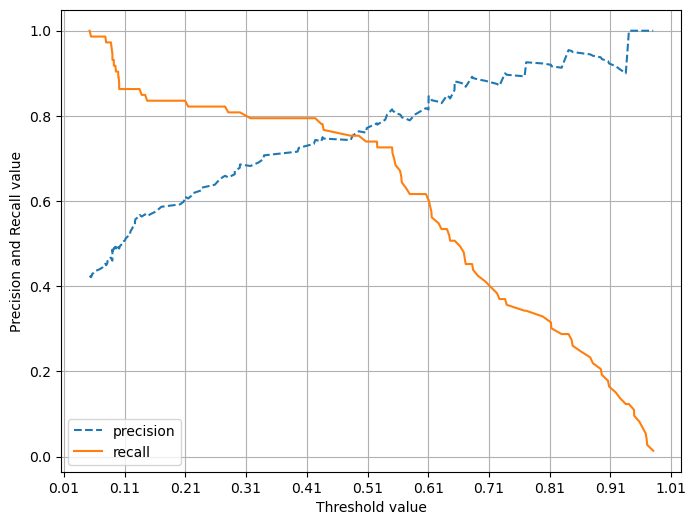

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시 
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경 
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축 y축 label과 legend, 그리고 grid 설정 
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr.predict_proba(X_test)[:, 1]) # 0.48 정도가 적당한 threshold임을 알 수 있음

In [25]:
lr.predict_proba(X_test)[:5]

array([[0.11874481, 0.88125519],
       [0.91024039, 0.08975961],
       [0.13826762, 0.86173238],
       [0.38937867, 0.61062133],
       [0.09383428, 0.90616572]])

## F1 Score
- 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐
- F1 = 2 * (precision * recall)/(precision + recall)
- ex)
    - A예측 모델의 경우 정밀도 0.9 재현율 0.1로 극단적인 차이가남
    - B예측 모들은 정밀도 0.5, 재현율 0.5로 큰 차이가 없음 
    - A예측 모델의 F1스코어는 0.18이고, B예측 모델의 F1스코어는 0.5로 B모델이 A모델에 비해 F1스코어가 우수함 

In [26]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f1)

0.75


In [27]:
def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # f1_score 추가
    f1 = f1_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    
    print('정확도 : {0: .4f}, 정밀도 : {1: .4f}, 재현율 : {2: .4f}, f1 : {3: .4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.05, 0.55, 0.60]
pred_proba = lr.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[85 21]
 [15 58]]
정확도 :  0.7989, 정밀도 :  0.7342, 재현율 :  0.7945, f1 :  0.7632
임곗값: 0.45
오차행렬
[[87 19]
 [18 55]]
정확도 :  0.7933, 정밀도 :  0.7432, 재현율 :  0.7534, f1 :  0.7483
임곗값: 0.05
오차행렬
[[ 7 99]
 [ 0 73]]
정확도 :  0.4469, 정밀도 :  0.4244, 재현율 :  1.0000, f1 :  0.5959
임곗값: 0.55
오차행렬
[[94 12]
 [20 53]]
정확도 :  0.8212, 정밀도 :  0.8154, 재현율 :  0.7260, f1 :  0.7681
임곗값: 0.6
오차행렬
[[96 10]
 [28 45]]
정확도 :  0.7877, 정밀도 :  0.8182, 재현율 :  0.6164, f1 :  0.7031


## ROC Curve와 AUC

- ROC Curve와 AUC score는 이진분류의 예측 성능 측정에서 중요하게 사용되는 지표
- 일반적으로 의학분야에서 많이 사용 되지만, 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가지표
- ROC 곡선은 FPR(False Positive Rate)이 변할 때, TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선
- FPR = x축, TPR = y축 
- FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타남
- **분류 성능 지표**로 사용되는것은 ROC곡선 면적에 기반한 **AUC값**으로 결정
- AUC(Area Under Curve) 값 =  ROC 곡선 밑의 면적 --> 1에 가까울수록 좋은 수치 (0.8 이상)
- TPR = 재현율 --> TP / (FN + TP)
- FPR = 실제 음성(Negative)을 잘못 예측한 비율 --> FP / (FP + TN)

In [38]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
print(thresholds.shape)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 6 step으로 추출
# thresholds[0]은 max(예측확률) +1로 임의 설정됨. 
# 이를 제외하기 위해 np.arange는 1부터 시작 
thr_index = np.arange(1, thresholds.shape[0], 6)
print('\n샘플 추출을 위한 임계값 배열의 index :', thr_index)
print('샘플 index로 추출한 임곗값 :', np.round(thresholds[thr_index]))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('\n샘플 임곗값 별 FPR :', np.round(fprs[thr_index], 3))
print('샘플 임곗값 별 TPR :', np.round(tprs[thr_index], 3))

(63,)

샘플 추출을 위한 임계값 배열의 index : [ 1  7 13 19 25 31 37 43 49 55 61]
샘플 index로 추출한 임곗값 : [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]

샘플 임곗값 별 FPR : [0.    0.028 0.066 0.094 0.16  0.255 0.368 0.632 0.679 0.764 0.981]
샘플 임곗값 별 TPR : [0.014 0.342 0.507 0.616 0.753 0.808 0.836 0.877 0.918 0.945 1.   ]


In [32]:
thresholds # thresholds[0]만 +1 됨을 확인

array([1.9806492 , 0.9806492 , 0.94066971, 0.9354658 , 0.84111531,
       0.82972132, 0.77143402, 0.76879963, 0.73654946, 0.72739013,
       0.68228728, 0.67176066, 0.65365042, 0.64608118, 0.64077862,
       0.63190955, 0.61513825, 0.61068017, 0.61039945, 0.60611809,
       0.57952344, 0.55047721, 0.52607332, 0.52554998, 0.5076036 ,
       0.49547847, 0.48235216, 0.4358627 , 0.4340371 , 0.42397851,
       0.31714251, 0.29992739, 0.28064028, 0.27527001, 0.26723025,
       0.25843128, 0.21461188, 0.20957847, 0.14707416, 0.14367294,
       0.13795562, 0.13455142, 0.10089616, 0.10089519, 0.1000485 ,
       0.09961066, 0.09912928, 0.09549857, 0.09477159, 0.09203283,
       0.09203193, 0.08979005, 0.08976591, 0.08975961, 0.08975156,
       0.08967593, 0.08725568, 0.07935263, 0.07815366, 0.05457788,
       0.05214954, 0.02898217, 0.00630912])

In [35]:
# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr.predict_proba(X_test)[:, 1]
print('max predict_proba :', np.max(pred_proba_class1))

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
print('thresholds 로우 수 :', thresholds.shape[0])
print('\nthresholds[0] :', thresholds[0])

# 반환된 임곗값 배열 로우가 63건 임으로 샘플로 10건만 추출하되, 임곗값을 6step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 6)
print('\n샘플 추출을 위한 임곗값 배열의 index 10개 :', thr_index) # index
print('샘플용 10개의 임곗값 :', np.round(thresholds[thr_index], 2)) # 해당 index의 thresholds 값

# 6step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('\n샘플 임곗값 별 FPR :', np.round(fprs[thr_index], 3))
print('샘플 임곗값 별 TPR :', np.round(tprs[thr_index], 3))

max predict_proba : 0.9806491989739388
thresholds 로우 수 : 63

thresholds[0] : 1.9806491989739388

샘플 추출을 위한 임곗값 배열의 index 10개 : [ 0  6 12 18 24 30 36 42 48 54 60]
샘플용 10개의 임곗값 : [1.98 0.77 0.65 0.61 0.51 0.32 0.21 0.1  0.09 0.09 0.05]

샘플 임곗값 별 FPR : [0.    0.019 0.047 0.094 0.16  0.255 0.368 0.623 0.651 0.755 0.934]
샘플 임곗값 별 TPR : [0.    0.342 0.507 0.603 0.74  0.795 0.822 0.863 0.918 0.945 1.   ]


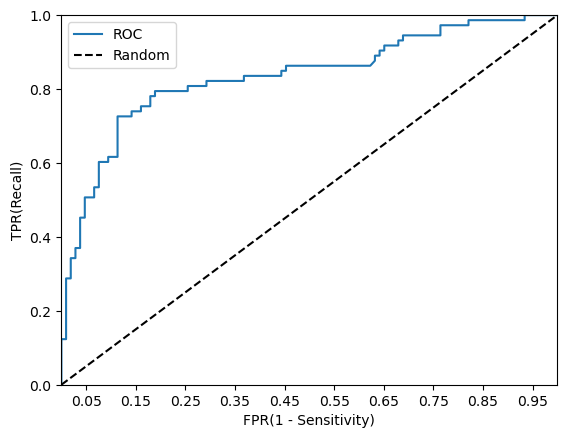

In [36]:
def roc_curve_plot(y_test, pred_proba_c1) :
    # 임곗값에 따른 FPR, TPR 값을 반환 받음 
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC Curve를 plot 곡선으로 그리기
    plt.plot(fprs, tprs, label = 'ROC')
    
    # 가운데 대각선 직선 그리기 
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경하고 X, Y축명 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)') ; plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr.predict_proba(X_test)[:, 1])

In [40]:
pred = lr.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('roc_score :', np.round(roc_score, 4))

pred_proba = lr.predict_proba(X_test)[: ,1]
roc_score_proba = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 :', np.round(roc_score_proba, 4))

roc_score : 0.7897
ROC AUC 값 : 0.8352


In [52]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    
    print('\n정확도:{0: .4f}, 정밀도:{1: .4f}, 재현율:{2: .4f}, f1:{3: .4f}, AUC:{4: .4f}'.format(accuracy, precision, recall,
                                                                                                 f1, roc_auc) )
 
pred = lr.predict(X_test) 
pred_proba_1 = lr.predict_proba(X_test)[:,1]  
get_clf_eval(y_test, pred, pred_proba_1)

오차행렬
[[89 17]
 [19 54]]

정확도: 0.7989, 정밀도: 0.7606, 재현율: 0.7397, f1: 0.7500, AUC: 0.8352


In [53]:
from sklearn.ensemble import RandomForestClassifier

tree = DecisionTreeClassifier()
rf = RandomForestClassifier()


model_tree = tree.fit(X_train, y_train)
model_rf = rf.fit(X_train, y_train)

pred_tree = model_tree.predict(X_test)
pred_rf = model_rf.predict(X_test)
proba_tree = model_tree.predict_proba(X_test)[:, 1]
proba_rf = model_rf.predict_proba(X_test)[:,  1]

get_clf_eval(y_test, pred_tree, proba_tree)
print()
get_clf_eval(y_test, pred_rf, proba_rf)

오차행렬
[[86 20]
 [28 45]]

정확도: 0.7318, 정밀도: 0.6923, 재현율: 0.6164, f1: 0.6522, AUC: 0.7041

오차행렬
[[91 15]
 [27 46]]

정확도: 0.7654, 정밀도: 0.7541, 재현율: 0.6301, f1: 0.6866, AUC: 0.8257
